In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("2025_COMBO.xlsx")

final_merged_df = df.groupby('Stock Code', as_index=False)['ZSCORE_FINAL'].mean()

final_merged_df.head(40)

column_list = final_merged_df['Stock Code'].tolist()
# print(column_list)



In [3]:
# df = pd.read_csv("C:/Users/meets/AVENTUS_FACTOR-MODEL/SIMPLE STRATEGY/mega_dateclose_final.csv")
# columns_to_keep = ['Date'] + [col for col in column_list if col in df.columns]
# filtered_with_date_df = df[columns_to_keep]


# filtered_with_date_df['Date'] = pd.to_datetime(filtered_with_date_df['Date'])
# start_date = pd.to_datetime("2024-03-31")
# end_date = pd.to_datetime("2025-04-02")
# filtered_df = filtered_with_date_df[(filtered_with_date_df['Date'] >= start_date) & (filtered_with_date_df['Date'] <= end_date)]
# filtered_df.head()


# df_cleaned = filtered_df.dropna(how='all', subset=filtered_df.columns.difference(['Date']))
# rows_removed = len(filtered_df) - len(df_cleaned)
# # print("ROWS REMOVED i.e. ALL VALUES MISSING EXCEPT DATE:", rows_removed)
# df_cleaned.head()


# df_fully_cleaned = df_cleaned.dropna(axis=1)
# final_columns = df_fully_cleaned.columns.tolist()
# if 'Date' in final_columns:
#     final_columns.remove('Date')
# print(final_columns)
# df_fully_cleaned.head()


# df_fully_cleaned['Date'] = pd.to_datetime(df_fully_cleaned['Date'])
# df_fully_cleaned.set_index('Date', inplace=True)
# pct_change_df = df_fully_cleaned.pct_change() 
# pct_change_df = pct_change_df.iloc[1:] 
# pct_change_df.head()
# # pct_change_df.to_csv("gptwork.csv",index=False)



# pct_change_df = pct_change_df.reset_index()  # This moves 'Date' from index to a regular column
# pct_change_df.head()
# # pct_change_df.to_csv("data1.csv",index=False) 





# # pct_change_df.to_csv("deletenow.csv",index=False)
# # nan_counts = pct_change_df.isna().sum()
# # print(nan_counts)
# # columns_without_nans = df.columns[df.isna().sum() == 0].tolist()
# # print(columns_without_nans)

# # pct_change_df.dropna

In [4]:
# PORTFOLIO WT CALCULATION

final_df = final_merged_df[final_merged_df['Stock Code'].isin([name.upper() for name in column_list])]
final_df.head()



# Step 1: Initial weights from Z-score
final_df['PORTFOLIO_WEIGHTS'] = final_df["ZSCORE_FINAL"] / final_df["ZSCORE_FINAL"].sum()

# Step 2: Cap and redistribute iteratively
cap = 0.07
weights = final_df['PORTFOLIO_WEIGHTS'].copy()

while True:
    over_cap = weights > cap
    if not over_cap.any():
        break  # Exit loop if no weights are over the cap

    # Cap the overweight stocks
    weights[over_cap] = cap

    # Redistribute the excess weight
    total_weight = weights.sum()
    excess = 1.0 - total_weight

    # Identify stocks eligible to receive excess (not capped)
    under_cap = weights < cap
    allocatable = weights[under_cap]
    scaling_sum = allocatable.sum()

    if scaling_sum == 0:
        break  # Avoid divide by zero

    # Distribute excess proportionally
    weights[under_cap] += (allocatable / scaling_sum) * excess

final_df['PORTFOLIO_WEIGHTS'] = weights

# Final checks (optional)
print("Max weight:", final_df['PORTFOLIO_WEIGHTS'].max())  # Should be <= 0.07
print("Total weight:", final_df['PORTFOLIO_WEIGHTS'].sum())  # Should be ~1.0


final_df = final_df[["Stock Code","PORTFOLIO_WEIGHTS"]]
final_df.head(20)


final_df.to_csv("2025_COMBO_OP_NEW.csv",index=False)

Max weight: 0.07
Total weight: 1.0


C:\Users\meets\AppData\Local\Temp\ipykernel_44956\3212921629.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['PORTFOLIO_WEIGHTS'] = final_df["ZSCORE_FINAL"] / final_df["ZSCORE_FINAL"].sum()
C:\Users\meets\AppData\Local\Temp\ipykernel_44956\3212921629.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['PORTFOLIO_WEIGHTS'] = weights


In [12]:
#DIRECT COPYPASTE - NO EDIT


# Align columns: ensure weights match the columns in the return dataframe
returns_df = pct_change_df.copy()
weights_df = final_df.set_index("Stock Code")["PORTFOLIO_WEIGHTS"]

# Ensure only common stocks are used
common_stocks = returns_df.columns.intersection(weights_df.index)
returns_matrix = returns_df[common_stocks].copy()
weights_vector = weights_df.loc[common_stocks]

# Perform matrix multiplication (dot product) for each date
returns_df["Portfolio Return"] = returns_matrix.dot(weights_vector)

# Show a few results
final_portfolio = returns_df[["Date", "Portfolio Return"]]
final_portfolio.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              240 non-null    datetime64[ns]
 1   Portfolio Return  240 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


In [13]:
#DIRECT COPYPASTE - NO EDIT

df2 = pd.read_csv("C:/Users/meets/AVENTUS_FACTOR-MODEL/SIMPLE STRATEGY/BENCHMARK/BSE500_PCTRETURNS_09-25.csv")
df2['BDP_Date'] = pd.to_datetime(df2['BDP_Date'])

final_portfolio_benchmark = pd.merge(final_portfolio, df2, how='inner', left_on='Date', right_on='BDP_Date')
final_portfolio_benchmark = final_portfolio_benchmark.drop('BDP_Date', axis=1)
final_portfolio_benchmark.set_index('Date', inplace=True)
final_portfolio_benchmark = final_portfolio_benchmark.rename(columns={'Portfolio Return':'Strategy'})
final_portfolio_benchmark.head()
final_portfolio_benchmark.to_csv("L_COMBO_FINAL_NEW.csv")
# final_portfolio_benchmark.to_csv("final_portfolio_benchmarkQ.csv")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-04-02   2024-04-02
End Period                 2025-03-18   2025-03-18
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          0.46%        -5.46%
CAGR﹪                     0.33%        -3.96%

Sharpe                     0.11         -0.13
Prob. Sharpe Ratio         54.23%       45.03%
Smart Sharpe               0.09         -0.1
Sortino                    0.14         -0.16
Smart Sortino              0.12         -0.13
Sortino/√2                 0.1          -0.11
Smart Sortino/√2           0.08         -0.09
Omega                      0.98         0.98

Max Drawdown               -18.96%      -33.06%
Longest DD Days            173          194
Volatility (ann.)          15.65%       23.82%
R^2                        0.62         0.62
Information Ratio          -0.02        -0.02
Calmar       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-09-06,2025-03-03,2025-03-18,194,-33.062909,-31.932055
2,2024-05-21,2024-06-04,2024-06-06,17,-7.210049,-5.760859
3,2024-07-10,2024-08-05,2024-08-20,42,-4.616632,-4.423360
4,2024-05-03,2024-05-09,2024-05-15,13,-4.278628,-3.630513
5,2024-04-12,2024-04-15,2024-04-19,8,-1.746981,-0.857718


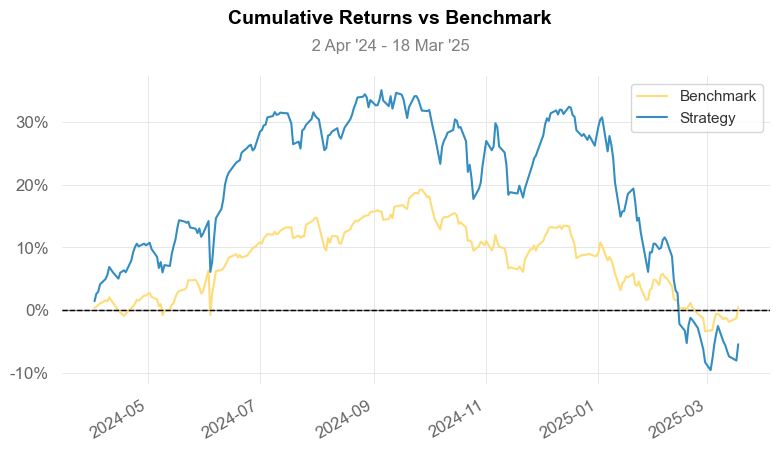

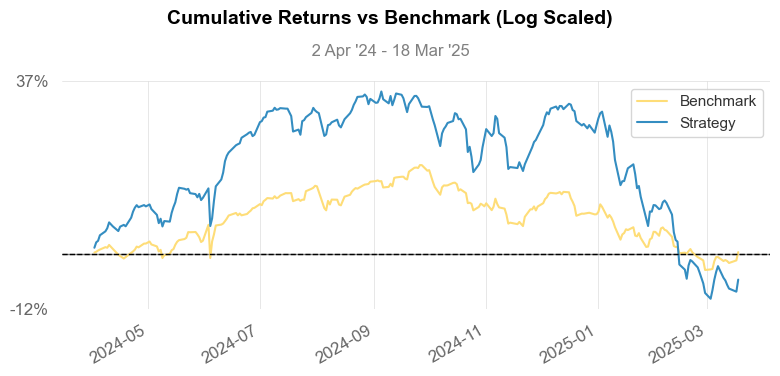

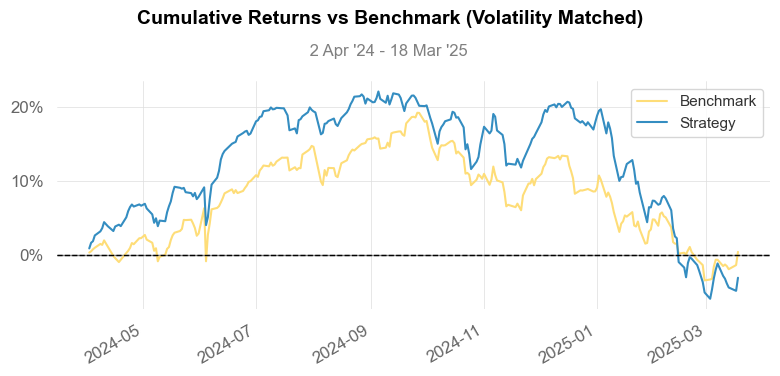

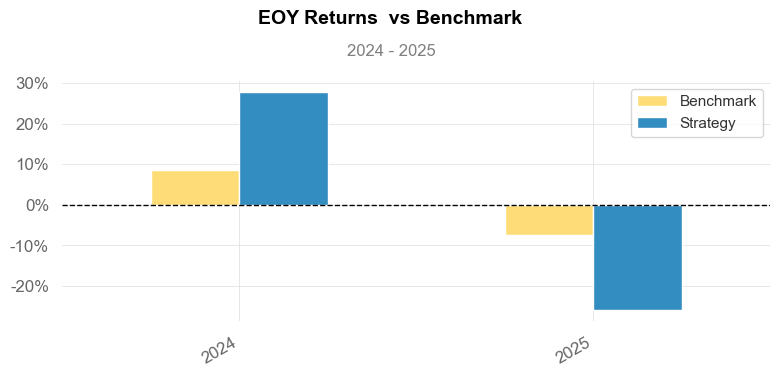

OptionError: No such keys(s): 'mode.use_inf_as_null'

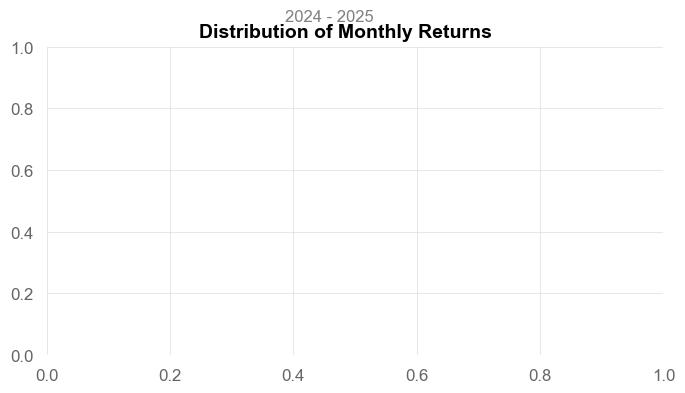

In [14]:
import quantstats as qs

final_portfolio_benchmark.index = pd.to_datetime(final_portfolio_benchmark.index)

qs.reports.full(final_portfolio_benchmark['Strategy'],benchmark = final_portfolio_benchmark['BDP_Close'],mode="full")